# Notebook #6: Let's try detecto again

So...here we are.  As a reminder to myself, what I'm trying to do at this point is:

1. get a model trained...
1. ...using augmented data...
1. ...actually make a prediction with it...
1. ...and save the model for further use.

In this notebook:

- I'll be using Detecto for training, etc as my wrapper of choice;
- I'll be using the Roboflow images for augmented data.

In future notebooks I'll explore the use of Pytorch Lighting Flash as the wrapper, and Albumentations (and possibly imgaug) for augmented data.

To start with, let's prepare for using this notebook either on a local computer, or in Colab:

In [2]:
import os
from pathlib import Path

if 'COLAB_GPU' in os.environ:
    print("I'm running on Colab")
    COLAB = True
    from google.colab import drive
    drive.mount('/content/gdrive')
    dataset_root = Path('/content/gdrive/MyDrive/dishwasher_training_data/roboflow')
else:
    print("Nope, not on Colab")
    COLAB = False
    dataset_root = Path('/home/aardvark/dev/src/dishwasher_training_data/roboflow')

training = dataset_root/'train/'
test = dataset_root/'test'
valid = dataset_root/'valid'

Nope, not on Colab


Next, let's create a training dataset.

**Note:** [Detecto's quickstart](https://detecto.readthedocs.io/en/latest/usage/quickstart.html) says that you can split data into training & validation folders; however, that does not appear to work for me, and [this docstring](https://github.com/alankbi/detecto/blob/2a22bb660af0c78b9ba7df643afb8dce62b8894c/detecto/core.py#L440-L447) for `Model.fit()` uses the approach I use below (separate datasets for each purpose).

In [18]:
from detecto.core import Dataset, DataLoader

training_dataset = Dataset(str(training))
validation_dataset = Dataset(str(valid))

Let's make sure a training image looks good:

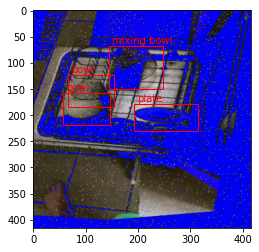

In [19]:
from detecto.visualize import show_labeled_image

image, targets = training_dataset[0]
show_labeled_image(image, targets['boxes'], targets['labels'])

Because I can never remember what I've labelled (still working on this discipline!), I'm including some code here to figure out the labels by examining the VOC files.

In [33]:
# https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python
import xml.etree.ElementTree as ET

# TODO: Misleading name, odd choice of things to return
# TODO: Find a proper library for VOC stuff
def read_bounding_box_and_labels(xml_file: str):
    """Get the bounding boxes and labels contained within a VOC XML file.
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter("object"):

        filename = root.find("filename").text

        xmin, ymin, xmax, ymax = None, None, None, None

        xmin = int(boxes.find("bndbox/xmin").text)
        ymin = int(boxes.find("bndbox/ymin").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        name = str(boxes.find("name").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax, name]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

def get_unique_labels_from_xml_file(xml_file: str):
    """Return set() of unique labels from within a VOC XML file
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    unique_labels = set()

    for boxes in root.iter("object"):
        name = boxes.find("name").text
        unique_labels.add(name)

    return unique_labels

def get_unique_labels_from_directory(directory: str):
    """Return a list of unique labels from all VOC XML files in a given directory.
    """
    dpath = Path(directory)
    labels = set()
    for f in dpath.glob("*xml"):
        try:
            new_set = get_unique_labels(f)
            labels |= new_set
        except Exception as e:
            # No labels, skip over 
            pass
        
    return list(labels)

In [34]:
labels = get_unique_labels_from_directory(training)
labels

['pot lid', 'mixing bowl', 'cup', 'pot', 'plate', 'bowl']

Now let's try training.

(Damn: should have done this:

```python
val_dataset = Dataset('validation_dataset/')
losses = model.fit(dataset, val_dataset, epochs=15, learning_rate=0.01,
                   gamma=0.2, lr_step_size=5, verbose=True)

plt.plot(losses)
plt.show()
```

In [37]:
from detecto.core import DataLoader, Model

model = Model(labels)
model.fit(training_dataset, verbose=True)

  0%|          | 0/33 [00:00<?, ?it/s]

It looks like you're training your model on a CPU. Consider switching to a GPU; otherwise, this method can take hours upon hours or even days to finish. For more information, see https://detecto.readthedocs.io/en/latest/usage/quickstart.html#technical-requirements
Epoch 1 of 10
Begin iterating over training dataset


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 of 10
Begin iterating over training dataset


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 of 10
Begin iterating over training dataset


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 of 10
Begin iterating over training dataset


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 of 10
Begin iterating over training dataset


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 of 10
Begin iterating over training dataset


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 of 10
Begin iterating over training dataset


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 of 10
Begin iterating over training dataset


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 of 10
Begin iterating over training dataset


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 33/33 [03:18<00:00,  6.01s/it]


Okay, model trained (though I forgot the verification dataset, DOH).  Let's see if we can get some predictions with our test dataset:

In [48]:
all_test_imgs = []

for i in test.glob("*jpg"):
    all_test_imgs.append(i)

all_test_imgs

[PosixPath('/home/aardvark/dev/src/dishwasher_training_data/roboflow/test/20-09-09-06-51-19-9754_jpg.rf.e60419bcdc9ed39569ebd7cc67df49cf.jpg'),
 PosixPath('/home/aardvark/dev/src/dishwasher_training_data/roboflow/test/20-11-30-06-46-08-0275_jpg.rf.adf2988ed6e6b2b0b8c59e6dc2e4565a.jpg')]

In [60]:
from detecto.utils import read_image
test_image = read_image(str(all_test_imgs[0]))

predicted_labels, predicted_boxes, predicted_confidence = model.predict_top(test_image)

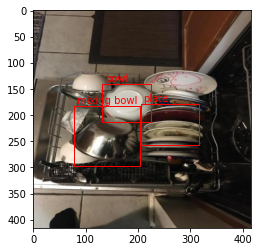

In [61]:
from detecto.visualize import show_labeled_image

show_labeled_image(test_image, predicted_boxes, predicted_labels)

Not bad!  What about the second one?

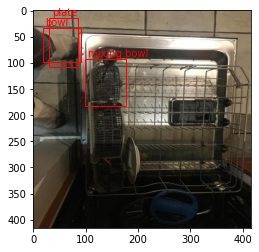

In [62]:
test_image_2 = read_image(str(all_test_imgs[1]))
predicted_labels_2, predicted_boxes_2, predicted_confidence_2 = model.predict_top(test_image_2)
show_labeled_image(test_image_2, predicted_boxes_2, predicted_labels_2)

#  🤣

In [63]:
model.save('../models/notebook_6-detecto_roboflow.pth')

In [64]:
!ls -l ../models/

total 647772
-rw-r--r--. 1 aardvark aardvark 165810830 Mar 12 14:14 detecto_model-0.0.1.pth
-rw-r--r--. 1 aardvark aardvark 165831976 Mar 12 14:14 detecto_model-0.0.2-paperspace.pth
-rw-r--r--. 1 aardvark aardvark 165831937 Mar 12 14:15 detecto_model-0.0.3-paperspace.pth
-rw-r--r--. 1 aardvark aardvark 165831310 Mar 14 17:49 notebook_6-detecto_roboflow.pth


Gotta figure out how to do this sort of thing consistently...but for now, we'll stick with that.

# Next steps

- ~~Load this model from the rest api~~
  - In predict.py as MODEL_6
- ~~Code to draw the image with bounding boxes, suitable for serving with the rest API~~
  - Done; see `draw_bounding_boxes()` in transforms.py
- Display that properly in results page
  - **NOT WORKING**.  See comment in transforms.py.

In [ ]:
# 